In [2]:
import os
from google.colab import userdata

In [3]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USER')

In [3]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.03G/1.04G [00:30<00:00, 43.3MB/s]
100% 1.04G/1.04G [00:30<00:00, 36.2MB/s]


In [8]:
# !unzip flickr8k.zip
# !mkdir working flickr8k
# !mv Images flickr8k
# !mv captions.txt flickr8k

In [4]:
import os
import pickle # to save the model
import numpy as np
from tqdm.notebook import tqdm  # to add process bar for loops & iterables


# keras    # Visual Geometry Group (VGG)
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input # for extracting the features from image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences  # for making same length of input
from tensorflow.keras.models import Model

# utilities
from tensorflow.keras.utils import to_categorical, plot_model  # to plot the model to see architecture of model

# layers
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [10]:
BASE_DIR = "flickr8k"
WORKING_DIR = "working"

## Extract Image features

In [7]:
model = VGG16()


# restructure the model
model = Model(inputs= model.inputs, outputs= model.layers[-2].output)  # taking the same input layer but ignore last output layer an just taking 2nd last layer of original VGG16 model


# summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Extract features from image
# key = image_id, value = image_features

features = {}
directory = os.path.join(BASE_DIR, "Images")

for image_name in tqdm(os.listdir(directory)):
  # load the image from file
  image_path = directory+ "/"+image_name
  image = load_img(image_path, target_size=(224,224)) # target_size is width, height
  # pixels to numpy array
  image = img_to_array(image)
  # reshape data for model
  image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))  # input img is RGB
  # preprocess img for VGG16 model
  image = preprocess_input(image)
  # extract features
  feature = model.predict(image, verbose=0) # don't display additional text
  # get Image ID
  image_id = image_name.split(".")[0]
  #store features
  features[image_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]

In [13]:
# store featuers in file
pickle.dump(features,open(os.path.join(WORKING_DIR, "features.pkl") , "wb"))

In [14]:
# load features from pickle
with open(os.path.join(WORKING_DIR, "features.pkl") , "rb") as file:
  features = pickle.load(file)


## Load the captions data

In [15]:
with open(os.path.join(BASE_DIR, "captions.txt") , "r") as file:
  next(file)  # igore the first line of captions.txt file
  captions_doc = file.read()

In [16]:
# mapping of image - captions {image_id:caption}
mapping = {}
for line in tqdm(captions_doc.split("\n")):
  # split the line by comma ','
  tokens = line.split(",")  # id, caption
  if len(tokens) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]  # captions may have ',' so index can be more than 1
  # remove the .jpg extension
  image_id = image_id.split(".")[0]
  # convert the caption list to single string
  caption = " ".join(caption)

  # create list if need as single img can have multiple captions
  if image_id not  in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

## Preprocess text data i.e Captions

In [17]:
# preprocess the captions

def clean_caption(mapping):
  for id, captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      # preprocessing steps
      # replace digits, special character
      caption = caption.lower().replace('[^A-Za-z]', '')
      # repalce additional places
      caption = caption.replace("\s+" , ' ')
      # remove small words
      caption = " ".join([word for word in caption.split() if len(word) >1 ])
      # add <start> and <end> tags to caption for model
      caption = "<start> " + caption + " <end>"
      captions[i] = caption


In [18]:
# before preprocess
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [19]:
#  preprocess
clean_caption(mapping)

In [20]:
# after preprocess
mapping['1000268201_693b08cb0e']

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [21]:
all_captions = [caption for key in mapping for caption in mapping[key]]
len(all_captions)

40455

In [22]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1  # +1 is for unknown word/padding


# Tokenization is breaking down sentence to token
# Token encoding is converting tokens to numerical format

In [23]:
# get maximum length of caption avaiable # helpful for padding
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [24]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.9)  # 90% data for training

train = image_ids[:split]
test = image_ids[split:]



Data Generator: Fetch image & caption in batch


In [37]:
# data generator will be helpful to avoid session crash due to low memory
# Create a data generator to get data in batch ( avoid session crash )

# def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):  # data_keys are img_ids
#   # loop over images
#   X1, X2, y = list(), list(), list()
#   n = 0 # determine weather we reach batch size or not
#   while 1:
#     for key in data_keys:
#       n += 1
#       captions = mapping[key]
#       # process each caption
#       for caption in captions:
#         # encode the sequence
#         seq = tokenizer.texts_to_sequences([caption])[0]  # generate the vector for single string caption present in vocab else None
#         # split the sequence into X, y pairs
#         """creating the list of next word predictor
#         example:   '<start> girl going into wooden building <end>'
#         X                                         y
#         <start>                                  girl
#         <start> girl                             goining
#         <start> girl goining                     into
#         <start> girl going into                  wooden
#         <start> girl going into wooden building  <end>
#         """
#         for i in range(1, len(seq)):
#           # split into X, y pair
#           input_seq, output_word = seq[:i], seq[i]
#           # perform padding on input sequence to make it length of max_length
#           input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
#           # encode the output word (one-hot encoding)
#           output_word = to_categorical([output_word], num_classes=vocab_size)[0]  # vocab_size tells us how many unique words are there in dict .. output format is like [0,0,0,1,0] 1 for being present no

#           # store the Sequences
#           X1.append(features[key][0])   # image feature
#           X2.append(input_seq)          # text feature
#           y.append(output_word)         # output word index
#       if n ==batch_size:
#         X1, X2, y = np.array(X1), np.array(X2), np.array(y)
#         yield [X1, X2], y
#         X1, X2, y = list(), list(), list()
#         n = 0
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        # Shuffling the data keys for each epoch
        np.random.shuffle(data_keys)

        for i in range(0, len(data_keys), batch_size):
            batch_keys = data_keys[i:i+batch_size]
            X1, X2, y = [], [], []

            for key in batch_keys:
                captions = mapping[key]
                for caption in captions:
                    seq = tokenizer.texts_to_sequences([caption])[0]
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                        X1.append(features[key][0])
                        X2.append(in_seq)
                        y.append(out_seq)

            # Convert to TensorFlow tensors
            yield (
                {
                    'input_layer_1': tf.convert_to_tensor(np.array(X1), dtype=tf.float32),
                    'input_layer_2': tf.convert_to_tensor(np.array(X2), dtype=tf.int32)
                },
                tf.convert_to_tensor(np.array(y), dtype=tf.float32)
            )

## Model ( Concatinating 2 features i.e img & caption )


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 35)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 4096)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 35, 256)        │      2,171,648 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 4096)           │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 35, 256)        │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, 35)             │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 256)            │      1,048,832 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 256)            │        525,312 │ dropout_7[0][0],       │
│                           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 256)            │              0 │ dense_9[0][0],         │
│                           │                        │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 256)            │         65,792 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 8483)           │      2,180,131 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,991,715 (22.86 MB)

 Trainable params: 5,991,715 (22.86 MB)

 Non-trainable params: 0 (0.00 B)

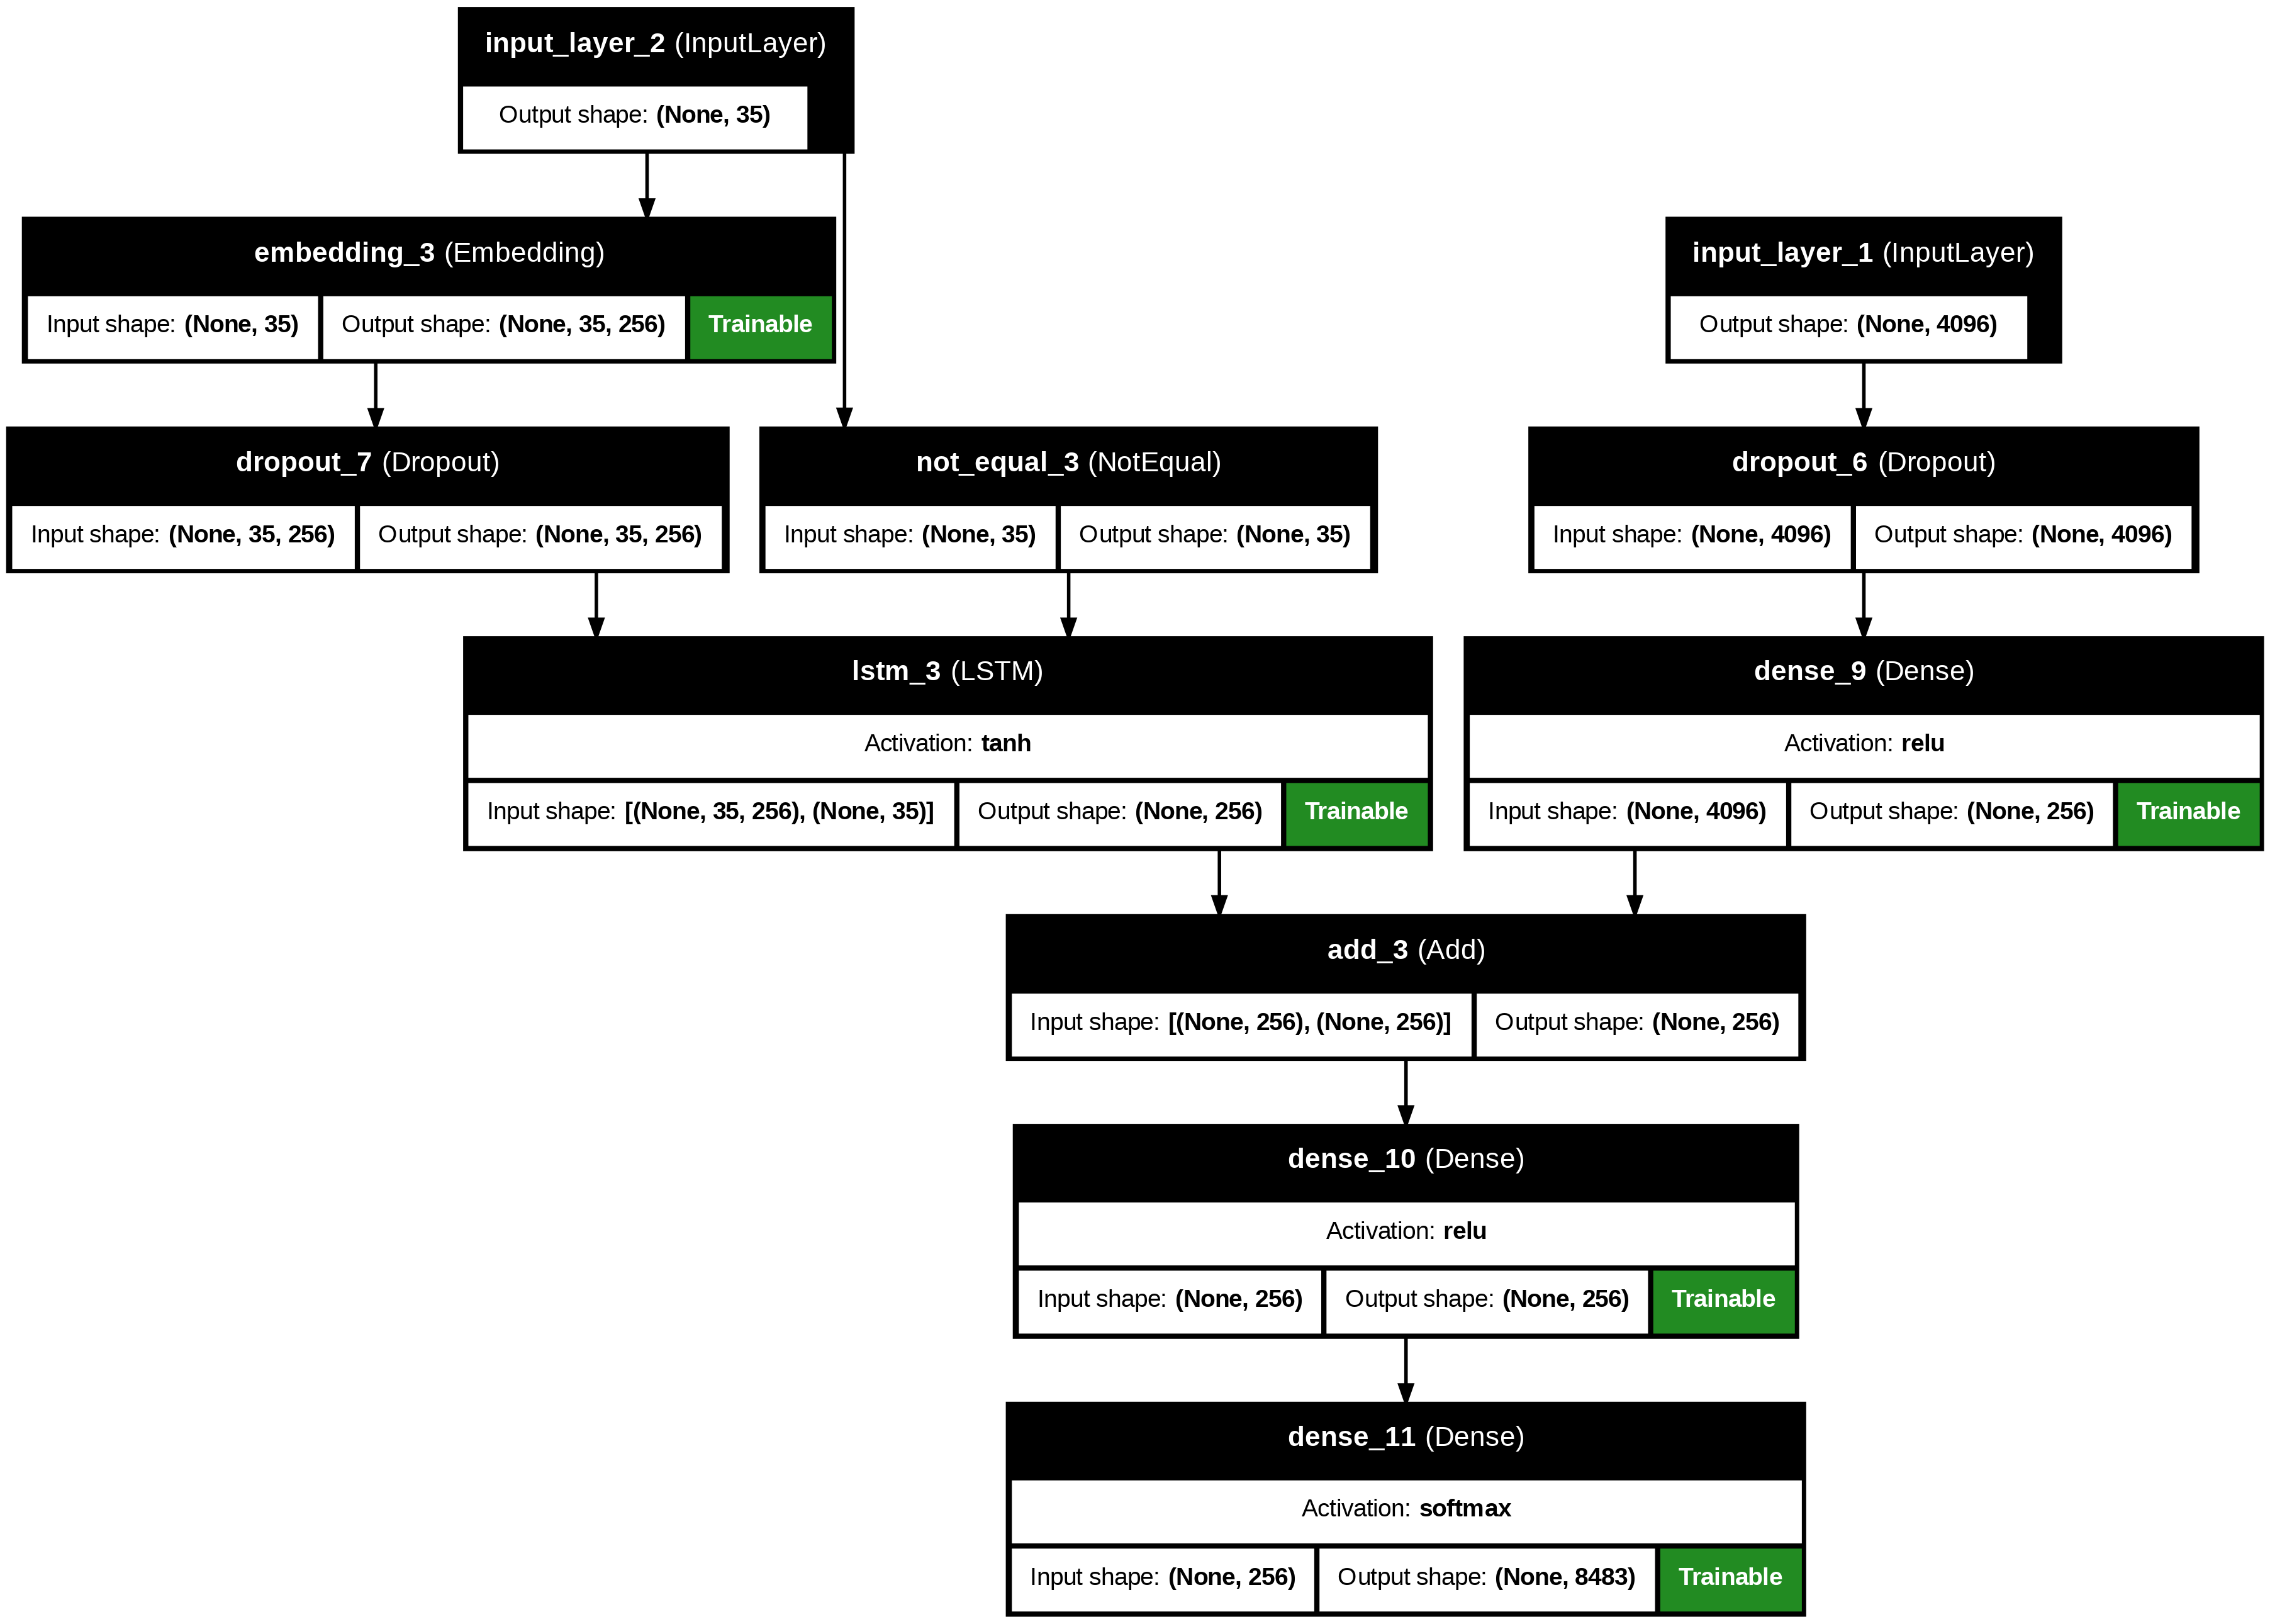

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Define input shapes
image_input_shape = (4096,)
caption_input_shape = (max_length,)

# Image feature layers
inputs1 = Input(shape=image_input_shape, name='input_layer_1')
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Caption (sequence) features layers
inputs2 = Input(shape=caption_input_shape, name='input_layer_2')
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)  # Disable cuDNN

# Decoder Model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Tie it together
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Build the model
model.build([(None, 4096), (None, max_length)])

# Print model summary
model.summary()
# plot the model
plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True,show_trainable=True, to_file='model.png')

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

# train the model
epochs = 1
batch_size = 64
steps_per_epoch = len(train) // batch_size

# Create a ModelCheckpoint callback with .keras extension
checkpoint = ModelCheckpoint(os.path.join(WORKING_DIR, "model_{epoch:02d}.keras"),
                             save_best_only=True, monitor='loss', mode='min')

# create data generator
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        # Shuffling the data keys for each epoch
        np.random.shuffle(data_keys)

        for i in range(0, len(data_keys), batch_size):
            batch_keys = data_keys[i:i+batch_size]
            X1, X2, y = [], [], []

            for key in batch_keys:
                captions = mapping[key]
                for caption in captions:
                    seq = tokenizer.texts_to_sequences([caption])[0]
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                        X1.append(features[key][0])
                        X2.append(in_seq)
                        y.append(out_seq)

            yield (
                {
                    'input_layer_1': np.array(X1, dtype=np.float32),
                    'input_layer_2': np.array(X2, dtype=np.int32)
                },
                np.array(y, dtype=np.float32)
            )

# Create a tf.data.Dataset from the generator
dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    output_signature=(
        {
            'input_layer_1': tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),
            'input_layer_2': tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )
)

# fit the model
history = model.fit(
    dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=[checkpoint],
    verbose=1
)

# After training, save the final model
model.save(os.path.join(WORKING_DIR, "final_model.keras"))

113/113 ━━━━━━━━━━━━━━━━━━━━ 399s 4s/step - loss: 5.7091


In [44]:
## Model will give us index of words

def idx_to_word(index, tokenizer):
  for word, idx in tokenizer.word_index.items():
    if idx == index:
      return word



## generate caption for an image

def predict_caption(model, image, tokenizer, max_length):
  # add <start> tag for generation process
  in_text = "<start>"
  # iterate over max_length of sequence
  for i in range(max_length):
    # encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad the sequence
    sequence = pad_sequences([sequence], max_length)
    # predict next word
    y_hat = model.predict([image,sequence], verbose=0)  # returns the probability of all vocab_size indexs. we need index with highest probablity
    # get index with high probability
    y_hat = np.argmax(y_hat)
    # convert index to word
    word = idx_to_word(y_hat, tokenizer)
    # stop if word not found
    if word is None:
      break
    # append word
    in_text += " " + word
    # stop if we reach end tag
    if word == "<end>":
      break
  return in_text


In [45]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)

  # split into words
  actual.append([caption.split() for caption in captions])
  predicted.append(y_pred.split())

# calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual,predicted, weights = (1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual,predicted, weights = (0.5,0.5,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.110802
BLEU-2: 0.060709


## visualize the results

In [48]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
  image_id = image_name.split(".")[0]
  img_path = os.path.join(BASE_DIR, "Images", image_name)
  image = Image.open(img_path)
  captions= mapping[image_id]
  print("------------------- Actual --------------------")
  for caption in captions:
    print(caption)
  print("-------------------- Predicted -----------------")
  y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
  print(y_pred)
  plt.imshow(image)

------------------- Actual --------------------
<start> brown dog plays in deep pile of snow <end>
<start> dog looking at the camera in snow <end>
<start> dog runs through the snow <end>
<start> tan dog stand in the snow and looks up <end>
<start> the brown dog is out in the snow <end>
-------------------- Predicted -----------------
<start> dog is running in the snow end end end end end end end end end end end end end end end end end end end end end end end end end end end end end


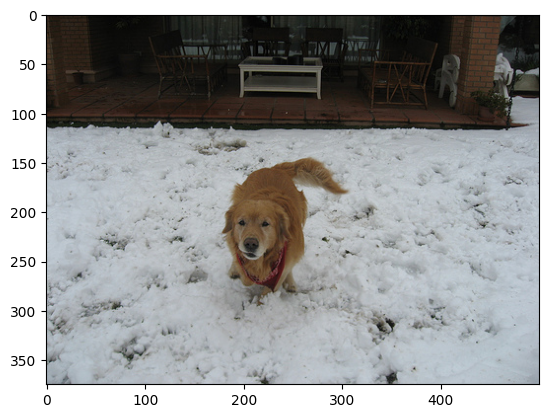

In [54]:
generate_caption(image_name = "1094462889_f9966dafa6.jpg")